In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-itba-2021-q2/y_train.npy
/kaggle/input/cnn-itba-2021-q2/X_test.npy
/kaggle/input/cnn-itba-2021-q2/X_train.npy


# Redes Neuronales 2021

Integrantes de grupo:

Müller, Malena

Scala, Tobías 
# TP3: Convolutional Neural Network (CNN) & Transfer Learning

El trabajo práctico consiste en la predicción de imagenes. El dataset utilizado es el CIFAR-100, el cual consiste de 60 mil imagenes (10 mil para test y 50 mil para train) con una variedad de 100 clases.Las imagenes tienen una resolución de 32x32 píxeles. Los 2 objetivos principales del presente TP son: el diseño de un modelo CNN y transfer learning con Imagenet. 


## Se obtiene el data set.
Se obtiene el dataset presente en Kaggle, el cual es el CIFAR-100. Se normalizan los píxeles dividiendo por 255.

In [2]:
trainX = np.load("../input/cnn-itba-2021-q2/X_train.npy")/255
trainY = np.load("../input/cnn-itba-2021-q2/y_train.npy")
testX = np.load("../input/cnn-itba-2021-q2/X_test.npy")/255

print(trainX.shape) #para ver cuantas imagenes hay (500 imágenes por cada clase. Hay 100 clases)
print(trainY.shape)
print(testX.shape)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)


## Dividimos train entre train y validation.
El dataset de train se lo divide en 80% de train y 20% de validation. Esto es para poder evaluar el performance de nuestros modelos con validation antes de predecir el test y luego hacer submit.

In [3]:
from sklearn.model_selection import train_test_split

trainX, validX, trainY, validY = train_test_split(trainX, trainY, test_size=0.2, random_state=0)

#validX = trainX[40000:,:,:,:]
#validY = trainY[40000:,:]
#trainX = trainX[:40000,:,:,:]
#trainY = trainY[:40000,:]

print(trainX.shape)
print(validX.shape)

(40000, 32, 32, 3)
(10000, 32, 32, 3)


Ploteamos una imagen para observar el contenido de train.

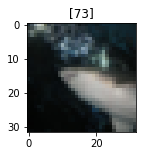

In [4]:
from matplotlib import pyplot as plt

plt.figure(figsize=(2,2)) #para cambiar tamaño de imagen
plt.imshow(trainX[0]) #agarra el elemento 0. Podria poner cualquier numero
plt.title(str(trainY[0]))
plt.show()

## Hacemos data augmentation para "aumentar" nuestro dataset.
Configuramos las capas que se encargarán de modificar, de forma aleatoria, las características de la imagen (horizontal flip, rotación, zoom y contraste) por cada iteración (epoch). Dado que estas capas se encargan de hacer el data augmentation, nuestro modelo asume que el dataset de train es mucho mayor a lo que es en realidad (40 mil imágenes).

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom, RandomContrast

dataAugmentation = Sequential([RandomFlip("horizontal",input_shape=trainX.shape[1:]),
                                RandomRotation(0.1),
                                RandomZoom(0.1),
                                RandomContrast(0.1)])

2021-12-01 13:27:35.115180: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 13:27:35.214986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 13:27:35.215715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-01 13:27:35.216800: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## Se diseña un modelo CNN.
El modelo CNN implementado respeta las estructuras mencionadas en clase (por ejemplo, VGG). Se generan capas convolucionales seguidos de capas maxpooling. Se agrega una capa dropout a modo de generalizar el dataset de train. La capa flatten es utilizada para generar un 1D vector. Finalmente tenemos una capa densa (fully connected) seguido de la capa de salida con función de activación softmax para la predicción de multiclases.

In [6]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

#Batch normalization applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1. It is
#a layer that normalizes its inputs.

Nclasses = 100
model = Sequential([dataAugmentation,
                    Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'),
                    MaxPooling2D(pool_size=(2, 2)),
                    Dropout(0.4),
                    Flatten(),
                    Dense(1024, activation='relu'),
                    #BatchNormalization(),
                    Dense(Nclasses, activation='softmax')])

#Use this SparseCategoricalCrossentropy loss function when there are two or more label classes. We expect labels to be provided as integers.
#If you want to provide labels using one-hot representation, please use CategoricalCrossentropy loss.

#Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

#Accuracy metric creates two local variables, total and count that are used to compute the frequency with which y_pred matches y_true. This
#frequency is ultimately returned as binary accuracy: an idempotent operation that simply divides total by count.

model.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 128)        

Entrenamos nuestro modelo.

In [7]:
model.fit(trainX, trainY, epochs=30, batch_size=64, verbose=1, workers=-1)

2021-12-01 13:27:39.149217: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


/opt/conda/lib/python3.7/site-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '
2021-12-01 13:27:40.783250: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


625/625 [==============================] - 10s 5ms/step - loss: 3.8642 - accuracy: 0.1064
Epoch 2/30
625/625 [==============================] - 3s 5ms/step - loss: 3.2403 - accuracy: 0.2091
Epoch 3/30
625/625 [==============================] - 3s 5ms/step - loss: 2.9755 - accuracy: 0.2622
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 2.7977 - accuracy: 0.2952
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 2.6546 - accuracy: 0.3231
Epoch 6/30
625/625 [==============================] - 3s 5ms/step - loss: 2.5361 - accuracy: 0.3478
Epoch 7/30
625/625 [==============================] - 3s 5ms/step - loss: 2.4475 - accuracy: 0.3686
Epoch 8/30
625/625 [==============================] - 3s 5ms/step - loss: 2.3669 - accuracy: 0.3826
Epoch 9/30
625/625 [==============================] - 3s 5ms/step - loss: 2.2903 - accuracy: 0.4004
Epoch 10/30
625/625 [==============================] - 3s 5ms/step - loss: 2.2150 - accuracy: 0.4167
Epoch 11/

Evalueamos nuestro modelo con validation.

In [8]:
model.evaluate(validX, validY)

313/313 [==============================] - 1s 3ms/step - loss: 2.4439 - accuracy: 0.4193


[2.443889617919922, 0.41929998993873596]

## Se hace transfer learning
Para implementar tranfer learning, se utilizan los pesos preentrenados de Imagenet. Se utilizará una estructura resnet de 50 capas que contendrá dichos pesos. Cabe mencionar que el modelo imagenet ha sido entrenado por imágenes de una resolución de 256x256 píxeles.

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50

#include_top: whether to include the fully-connected layer at the top of the network.

#weights: one of None (random initialization), 'imagenet' (pre-training on ImageNet), or the path to the weights file to be loaded.

#trainable: Boolean, whether the layer's variables (weights) should be trainable (updated).

#La red arranca preentrenada.
modelResnet = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3), classes=100)
for layer in modelResnet.layers:
    if not isinstance(layer, BatchNormalization):
        layer.trainable = False
#for layer in modelResnet.layers:
#    layer.trainable = False 

94781440/94765736 [==============================] - 0s 0us/step


In [10]:
from tensorflow.keras.applications.resnet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

#Preprocesses a tensor or Numpy array encoding a batch of images. The images are converted from RGB to BGR, 
#then each color channel is zero-centered with respect to the ImageNet dataset, without scaling.
trainX = preprocess_input(trainX)
validX = preprocess_input(validX)
testX = preprocess_input(testX)

Se agregan capas al final para adaptar el modelo preentrenado a nuestro problema (ya que hay pesos que no son entrenables). Como primera capa tenemos el data augmentation explicado anteriormente. Luego se usan capas upsampling (cada una duplica el tamaño) para que la resolución para la cual Imagenet fue entrenado (256x256) coincida con la resolución utilizada en CIFAR-100 (32x32). Luego se agrega el modelo preentrenado (resnet50). Se agrega una capa dropout por lo mencionado anteriormente.

In [11]:
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, UpSampling2D

#GlobalAveragePooling2D: Downsamples the input along its spatial dimensions (height and width) by taking the average value over an input
#window (of size defined by pool_size) for each channel of the input. The window is shifted by strides along each dimension.

model_ = Sequential([dataAugmentation,
                    UpSampling2D(),
                    UpSampling2D(),
                    UpSampling2D(),
                    modelResnet, #Acá está el modelo preentrenado.
                    GlobalAveragePooling2D(),
                    Dense(256, activation='relu'),
                    Dropout(0.4),
                    BatchNormalization(),
                    Dense(Nclasses, activation='softmax')])

model_.compile(optimizer='adam', loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
model_.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 32, 32, 3)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 64, 64, 3)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 3)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

Entrenamos el modelo preentrenado con el dataset de nuestro problema. Cabe mencionar que con menos epochs, se ha logrado un accuracy mucho mayor que con el modelo no preentrenado.

In [12]:
model_.fit(trainX, trainY, epochs=15, batch_size=64, verbose=1, workers=-1)

Epoch 1/15
625/625 [==============================] - 177s 276ms/step - loss: 3.4474 - accuracy: 0.1921
Epoch 2/15
625/625 [==============================] - 173s 276ms/step - loss: 2.2837 - accuracy: 0.3982
Epoch 3/15
625/625 [==============================] - 173s 276ms/step - loss: 1.8505 - accuracy: 0.4926
Epoch 4/15
625/625 [==============================] - 173s 276ms/step - loss: 1.6277 - accuracy: 0.5460
Epoch 5/15
625/625 [==============================] - 173s 276ms/step - loss: 1.4923 - accuracy: 0.5792
Epoch 6/15
625/625 [==============================] - 173s 276ms/step - loss: 1.4116 - accuracy: 0.5992
Epoch 7/15
625/625 [==============================] - 173s 276ms/step - loss: 1.3347 - accuracy: 0.6201
Epoch 8/15
625/625 [==============================] - 173s 276ms/step - loss: 1.2718 - accuracy: 0.6371
Epoch 9/15
625/625 [==============================] - 173s 276ms/step - loss: 1.2193 - accuracy: 0.6487
Epoch 10/15
625/625 [==============================] - 173s 276m

Evaluemos nuestro modelo preentrenado.

In [13]:
model_.evaluate(validX, validY)

313/313 [==============================] - 22s 66ms/step - loss: 0.8673 - accuracy: 0.7444


[0.8672987222671509, 0.7444000244140625]

Predecimos el test.

In [14]:
testPred = model_.predict(testX)
testPred = testPred.argmax(axis=1) #argmax: Returns the indices of the maximum values along an axis.

Preparamos submission.

In [15]:
df = pd.DataFrame(data=testPred, columns=["label"])
df.index.name="Id"
df.head()

,label
Id,
0,68
1,33
2,55
3,51
4,71


In [16]:
df.to_csv("submission.csv")